## Looking at the first ten results from RAG 

In [146]:
litigation_csv = '../litigation_df/litigation_w_decisions.csv'
import pandas as pd
litigation_df = pd.read_csv(litigation_csv, encoding='utf-8')

In [147]:
len(litigation_df)

451

In [148]:
# find rows where Name_x and date_filing are the same and remove the second instance 

#this means we are losing some information on decision dates (because sometimes there are multiple) but will allow for a cleaner analysis on filing dates 

litigation_df = litigation_df.drop_duplicates(subset=['Name_x', 'date_filing'], keep='last')

In [149]:
len(litigation_df)

388

In [150]:
litigation_df

,Name_x,Name_y,case_x,case_y,date_filing,date_decision,impact,Positive or negative
1,American Electric Power,American Electric Power,Connecticut v. Am. Elec. Power,Connecticut v. Am. Elec. Power,7/21/2004,5/13/2010,3.0,NaN
3,General Motors Co,General Motors Co,California v. GM Corp.,California v. GM Corp.,9/20/2006,9/17/2007,3.0,NaN
4,Volkswagen,Volkswagen,Germanwatch vs. Volkswagen,Germanwatch vs. Volkswagen,05/07/2007,11/20/2007,3.0,NaN
5,General Motors Co,General Motors Co,Australian Competition & Consumer Commission v...,Australian Competition & Consumer Commission v...,1/16/2008,9/18/2008,-3.0,NaN
6,Duke Energy,Duke Energy,Sierra Club v. Duke Energy Indiana,Sierra Club v. Duke Energy Indiana,02/12/2008,11/24/2010,3.0,NaN
...,...,...,...,...,...,...,...,...
446,Delta Air Lines,0,Complaint against Virgin Atlantic and British ...,NaN,11/30/2023,NaN,NaN,NaN
447,Repsol SA,Repsol SA,Iberdrola and others vs. Repsol,Iberdrola and others vs. Repsol,2/21/2024,4/16/2024,NaN,Positive
448,ING Group,0,Milieudefensie v. ING Bank,NaN,1/19/2024,NaN,NaN,NaN
449,AIG,AIG,Aloha Petroleum Ltd. v. National Union Fire In...,Aloha Petroleum Ltd. v. National Union Fire In...,08/10/2022,10/07/2024,NaN,Positive


In [151]:
#subset this to only our ten companies of interest at the moment 
companies = ['American Electric Power', 'The AES Corporation', 'AIG', 'Peabody','Citigroup Inc', 'Colgate-Palmolive Co', 'CNX Resources', 'Conocophillips', 'Carnival PLC', 'Chevron']

litigation_df = litigation_df[litigation_df['Name_x'].isin(companies)]

For current purposes, we are only concerned with the company sued and the date of the suit, so we are going to remove all other columnns 

In [152]:
litigation_df_filtered = litigation_df[['Name_x', 'date_filing', 'date_decision']]

In [153]:
#trim the date_filing column to just the year 
litigation_df_filtered['date_filing'] = pd.to_datetime(litigation_df_filtered['date_filing']).dt.year
#trim the date_decision column to just the year
litigation_df_filtered['date_decision'] = pd.to_datetime(litigation_df_filtered['date_decision']).dt.year

/var/folders/br/4mkn2pts7yg8xb1_dfd6g01c0000gn/T/ipykernel_91896/2325328687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  litigation_df_filtered['date_filing'] = pd.to_datetime(litigation_df_filtered['date_filing']).dt.year
/var/folders/br/4mkn2pts7yg8xb1_dfd6g01c0000gn/T/ipykernel_91896/2325328687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  litigation_df_filtered['date_decision'] = pd.to_datetime(litigation_df_filtered['date_decision']).dt.year


In [154]:
litigation_df_filtered

,Name_x,date_filing,date_decision
1,American Electric Power,2004,2010.0
10,Chevron,2008,2012.0
16,Peabody,2008,2012.0
18,American Electric Power,2008,2010.0
29,Chevron,2011,2010.0
...,...,...,...
432,Chevron,2024,NaN
433,Conocophillips,2024,NaN
438,Chevron,2024,NaN
439,Conocophillips,2024,NaN


In [191]:
# extract the peabody cases and save them to a separate csv
peabody_df = litigation_df_filtered[litigation_df_filtered['Name_x'] == 'Peabody']

## Getting yearly counts of active suits

In [155]:
df = litigation_df_filtered.copy()
df['date_filing']   = df['date_filing'].astype(int)
df['date_decision'] = df['date_decision'].fillna(2025).astype(int)

df

,Name_x,date_filing,date_decision
1,American Electric Power,2004,2010
10,Chevron,2008,2012
16,Peabody,2008,2012
18,American Electric Power,2008,2010
29,Chevron,2011,2010
...,...,...,...
432,Chevron,2024,2025
433,Conocophillips,2024,2025
438,Chevron,2024,2025
439,Conocophillips,2024,2025


In [156]:
def active_years(row, last_year=2025):
    start = row['date_filing']
    end   = row.get('date_decision', None)
    if pd.isna(end):
        end = last_year
    return list(range(start, end + 1))


In [157]:
df['active_years'] = df.apply(active_years, axis=1)
exploded = df.explode('active_years')

# count how many cases cover each year
yearly_counts = (
    exploded
    .groupby('active_years')
    .size()
    .rename('active_cases')
    .sort_index()
)

In [158]:
yearly_df = yearly_counts.reset_index()
yearly_df.columns = ['year', 'active_cases']


In [159]:
yearly_df

,year,active_cases
0,2004,1
1,2005,1
2,2006,1
3,2007,1
4,2008,5
5,2009,5
6,2010,5
7,2011,3
8,2012,3
9,2015,4


In [160]:
# cut off before 2014 
yearly_df = yearly_df[yearly_df['year'] >= 2014]

In [161]:
yearly_df

,year,active_cases
9,2015,4
10,2016,4
11,2017,11
12,2018,24
13,2019,24
14,2020,36
15,2021,43
16,2022,42
17,2023,49
18,2024,47


In [162]:
# now I also want to plot the number of cases filed each year
yearly_filing_counts = (
    df
    .groupby('date_filing')
    .size()
    .rename('filing_cases')
    .sort_index()
)
yearly_filing_df = yearly_filing_counts.reset_index()

yearly_filing_df = yearly_filing_df[yearly_filing_df['date_filing'] >= 2014]

In [163]:
yearly_filing_df

,date_filing,filing_cases
3,2015,4
4,2017,7
5,2018,13
6,2020,12
7,2021,7
8,2022,1
9,2023,7
10,2024,4


_______

## Loading in company results

In [164]:
import pandas as pd
from pathlib import Path

base_dir = Path("rag_results")
all_dfs = []

for company_dir in base_dir.iterdir():
    if not company_dir.is_dir():
        continue
    # you said each CSV already has a company column,
    # so we don’t need to re-add it here
    
    for year_dir in company_dir.iterdir():
        if not year_dir.is_dir() or not year_dir.name.isdigit():
            continue
        year = int(year_dir.name)
        
        # assume exactly one CSV per year folder
        csv_files = list(year_dir.glob("*.csv"))
        if not csv_files:
            continue
        
        df = pd.read_csv(csv_files[0])
        df["year"] = year
        all_dfs.append(df)

# concatenate all years & companies
combined_df = pd.concat(all_dfs, ignore_index=True)

# quick sanity‐check
print(combined_df.shape)
print(combined_df["year"].unique())


(11957, 7)
[2014 2022 2025 2024 2023 2015 2017 2019 2021 2020 2018 2016]


In [165]:
combined_df

,company,original_index,year,text,climate_litigation,retrieval_similarity,num_examples_used
0,CNX,53,2014,"Internationally, the Kyoto Protocol, which set...",climate_litigation: 0,0.636538,5
1,CNX,52,2014,"In May 2010, the EPA proposed new approaches f...",climate_litigation: 0,0.636336,5
2,CNX,35,2014,Environmental Laws\nClean Air Act and Related ...,climate_litigation: 0,0.631410,5
3,CNX,36,2014,"In addition, in August 2012, the U.S. Court of...",climate_litigation: 0,0.614631,5
4,CNX,37,2014,"In addition, the Spill Prevention, Control and...",climate_litigation: 0,0.609224,5
...,...,...,...,...,...,...,...
11952,AES,56,2016,Sao Paulo state does not have a good potential...,climate_litigation: 0,0.519227,5
11953,AES,6,2016,NYSE New York Stock Exchange O&M Operations an...,climate_litigation: 0,0.518726,5
11954,AES,130,2016,"At the time of abandonment, we would expense a...",climate_litigation: 0,0.518720,5
11955,AES,258,2016,Items subject to such estimates and assumption...,climate_litigation: 0,0.518572,5


In [190]:
# extract the BTU df 
btu_df = combined_df[combined_df['company'] == 'BTU']

In [166]:
import re 

trouble_indices = []

def extract_flag(val, idx):
    """
    Look for standalone 0s or 1s in the string form of val.
    Returns:
      0 or 1 if exactly one is found,
      pd.NA otherwise (and records idx in trouble_indices).
    """
    s = str(val)
    # find all standalone digits 0 or 1
    matches = set(re.findall(r'\b[01]\b', s))
    
    if matches == {'0'}:
        return 0
    elif matches == {'1'}:
        return 1
    else:
        # either matches == set(), or matches == {'0','1'}
        trouble_indices.append(idx)
        return pd.NA

In [167]:
combined_df['climate_litigation_binary'] = combined_df.apply(
    lambda row: extract_flag(row['climate_litigation'], row.name), 
    axis=1
)

In [168]:
trouble_df = combined_df.loc[trouble_indices, ['climate_litigation']]
print("Rows needing manual review:")
print(trouble_df)

Rows needing manual review:
      climate_litigation
10121            SKIPPED
10122            SKIPPED
10123            SKIPPED
10124            SKIPPED
10125            SKIPPED
10126            SKIPPED
10127            SKIPPED
10128            SKIPPED
10129            SKIPPED
10130            SKIPPED
10131            SKIPPED
10132            SKIPPED
10133            SKIPPED
10134            SKIPPED
10135            SKIPPED
10136            SKIPPED
10137            SKIPPED


**NOTE: These rows weren't assesed for some reason (I'm not sure why). Ok for now, for poster, but will want to go back to those in the future** 

In [169]:
df_1s = combined_df[combined_df['climate_litigation_binary'] == 1]

In [170]:
df_1s

,company,original_index,year,text,climate_litigation,retrieval_similarity,num_examples_used,climate_litigation_binary
100,CNX,60,2022,"Environmental, social and governance (ESG) goa...",climate_litigation: 1,0.701189,5,1
101,CNX,58,2022,"Our loss of these rights, through our inabilit...",climate_litigation: 1,0.680915,5,1
120,CNX,66,2022,This expectation is based upon assumptions we ...,climate_litigation: 1,0.572751,5,1
200,CNX,58,2025,While new laws and regulations that are aimed ...,climate_litigation: 1,0.699327,5,1
201,CNX,56,2025,"Our loss of these rights, through our inabilit...",climate_litigation: 1,0.672579,5,1
...,...,...,...,...,...,...,...,...
11659,AES,106,2020,See\nItem 7.—Management's Discussion and Analy...,climate_litigation: 1,0.662654,5,1
11661,AES,100,2020,Any of these outcomes could have a material ad...,climate_litigation: 1,0.634509,5,1
11759,AES,110,2018,Of the approximately 28.7 million metric tonne...,climate_litigation: 1,0.658740,5,1
11778,AES,65,2018,The NSPS establish CO 2\nemissions standards o...,climate_litigation: 1,0.576829,5,1


In [171]:
# count the presence of 1s by year 
yearly_1s_counts = (
    df_1s
    .groupby('year')
    .size()
    .rename('climate_litigation_cases')
    .sort_index()
)
yearly_1s_df = yearly_1s_counts.reset_index()

In [172]:
yearly_1s_df = yearly_1s_df[yearly_1s_df['year'] < 2025]

In [173]:
yearly_df = yearly_df[yearly_df['year'] < 2025]

In [174]:
yearly_df

,year,active_cases
9,2015,4
10,2016,4
11,2017,11
12,2018,24
13,2019,24
14,2020,36
15,2021,43
16,2022,42
17,2023,49
18,2024,47


In [175]:
yearly_filing_df

,date_filing,filing_cases
3,2015,4
4,2017,7
5,2018,13
6,2020,12
7,2021,7
8,2022,1
9,2023,7
10,2024,4


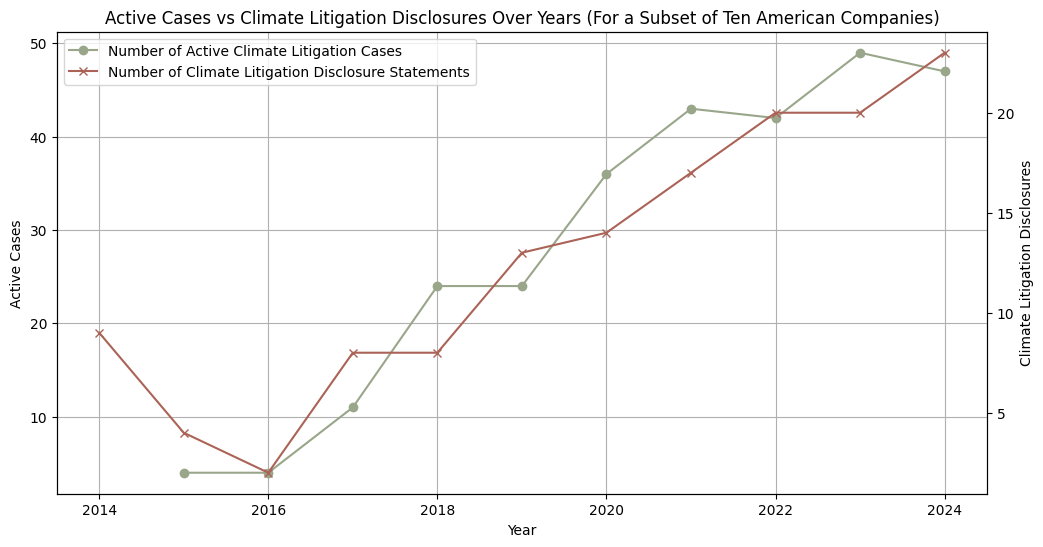

In [210]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Active Cases on left y-axis, color #99a68a
ax1.plot(
    yearly_df['year'],
    yearly_df['active_cases'],
    label='Number of Active Climate Litigation Cases',
    marker='o',
    color='#99a68a'
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Active Cases')
ax1.grid(True)

# Climate Litigation Disclosures on right y-axis, color #ab6357
ax2 = ax1.twinx()
ax2.plot(
    yearly_1s_df['year'],
    yearly_1s_df['climate_litigation_cases'],
    label='Number of Climate Litigation Disclosure Statements',
    marker='x',
    color='#ab6357'
)
ax2.set_ylabel('Climate Litigation Disclosures')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Active Cases vs Climate Litigation Disclosures Over Years (For a Subset of Ten American Companies)')
plt.show()


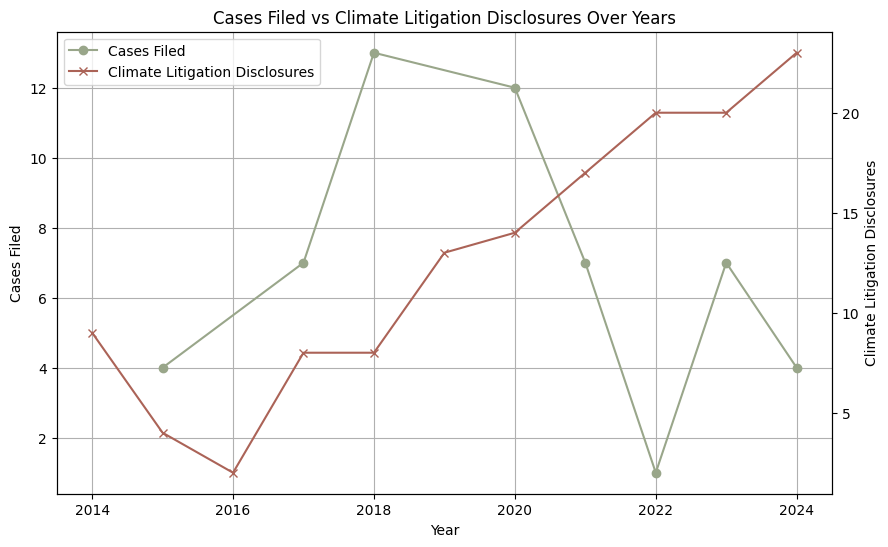

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Cases Filed on left y-axis in #99a68a
ax1.plot(
    yearly_filing_df['date_filing'],
    yearly_filing_df['filing_cases'],
    label='Cases Filed',
    marker='o',
    color='#99a68a'
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Cases Filed')
ax1.grid(True)

# Climate Litigation Cases on right y-axis in #ab6357
ax2 = ax1.twinx()
ax2.plot(
    yearly_1s_df['year'],
    yearly_1s_df['climate_litigation_cases'],
    label='Climate Litigation Disclosures',
    marker='x',
    color='#ab6357'
)
ax2.set_ylabel('Climate Litigation Disclosures')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Cases Filed vs Climate Litigation Disclosures Over Years')
plt.show()


## Looking only at Peabody

In [199]:
btu_df_1s = btu_df[btu_df['climate_litigation_binary'] == 1]
btu_yearly_1s_counts = (
    btu_df_1s
    .groupby('year')
    .size()
    .rename('climate_litigation_cases')
    .sort_index()
)
btu_yearly_1s_df = btu_yearly_1s_counts.reset_index()
btu_yearly_1s_df = btu_yearly_1s_df[btu_yearly_1s_df['year'] < 2025]
btu_yearly_1s_df

,year,climate_litigation_cases
0,2014,1
1,2015,2
2,2016,1
3,2017,4
4,2018,3
5,2019,5
6,2020,3
7,2021,5
8,2022,4
9,2023,2


In [200]:
peabody_df

,Name_x,date_filing,date_decision
16,Peabody,2008,2012.0
67,Peabody,2015,NaN
100,Peabody,2017,NaN
430,Peabody,2023,NaN


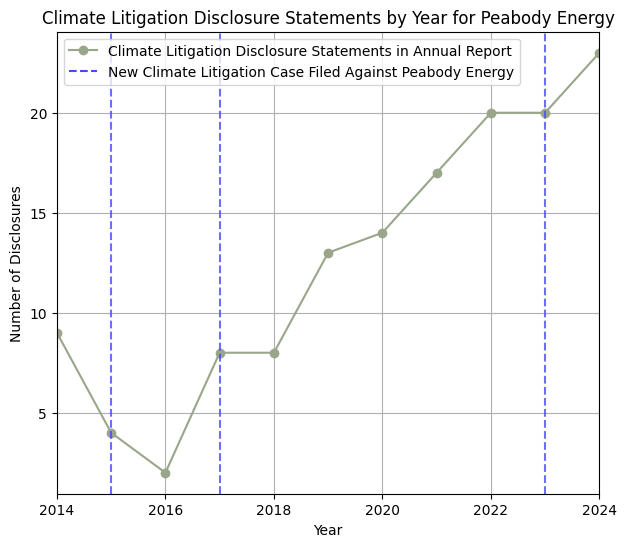

In [211]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming `yearly_1s_df` is defined
df = yearly_1s_df[yearly_1s_df['year'] >= 2014]
new_case_years = [2015, 2017, 2023]

fig, ax = plt.subplots(figsize=(7, 6))

# Plot disclosures line
line_main, = ax.plot(
    df['year'],
    df['climate_litigation_cases'],
    marker='o',
    color='#99a68a',
    label='Disclosures'
)

# Plot dashed vertical lines for new cases
for yc in new_case_years:
    if yc >= df['year'].min() and yc <= df['year'].max():
        ax.axvline(yc, color='#4848ff', linestyle='--', alpha=0.8)

# Styling
ax.set_xlim(2014, df['year'].max())
ax.set_xlabel('Year')
ax.set_ylabel('Number of Disclosures')
ax.set_title('Climate Litigation Disclosure Statements by Year for Peabody Energy')
ax.grid(True)

# Create custom legend entry for new case indicator
legend_elements = [
    Line2D([0], [0], color='#99a68a', marker='o', label='Climate Litigation Disclosure Statements in Annual Report'),
    Line2D([0], [0], color='#4848ff', linestyle='--', label='New Climate Litigation Case Filed Against Peabody Energy'),
]
ax.legend(handles=legend_elements, loc='upper left')

plt.show()
